In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn import preprocessing
import category_encoders as ce
import pickle

In [4]:
df = pd.read_csv("data_1D.csv")
df.head()

,Unnamed: 0,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,y
0,0,83,retired,divorced,basic.4y,no,no,no,cellular,nov,tue,242.0,1,3,3,success,yes
1,1,32,services,married,high.school,no,no,no,telephone,may,tue,190.0,3,999,0,nonexistent,no
2,2,31,admin.,single,university.degree,no,yes,no,telephone,may,wed,325.0,2,999,0,nonexistent,no
3,3,33,admin.,single,university.degree,no,yes,no,telephone,aug,thu,158.0,1,999,0,nonexistent,no
4,4,39,services,married,high.school,no,yes,no,telephone,jul,mon,158.0,1,999,0,nonexistent,no


Input variables:

1.  age (numeric)

2.  job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')

3.  marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)

4.  education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')

5.  default: has credit in default? (categorical: 'no','yes','unknown')

6.  housing: has housing loan? (categorical: 'no','yes','unknown')

7.  loan: has personal loan? (categorical: 'no','yes','unknown')

8.  contact: contact communication type (categorical: 'cellular','telephone')

9.  month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

10.  day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')

11.  duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

12.  campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

13.  pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

14.  previous: number of contacts performed before this campaign and for this client (numeric)

15.  poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

Output variable (desired target):

16.  y - has the client subscribed a term deposit? (binary: 'yes','no')

# Initial Checking & Data Cleaning
### Removing unecessary columns

In [5]:
df = df.drop(columns=["Unnamed: 0"])
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,y
0,83,retired,divorced,basic.4y,no,no,no,cellular,nov,tue,242.0,1,3,3,success,yes
1,32,services,married,high.school,no,no,no,telephone,may,tue,190.0,3,999,0,nonexistent,no
2,31,admin.,single,university.degree,no,yes,no,telephone,may,wed,325.0,2,999,0,nonexistent,no
3,33,admin.,single,university.degree,no,yes,no,telephone,aug,thu,158.0,1,999,0,nonexistent,no
4,39,services,married,high.school,no,yes,no,telephone,jul,mon,158.0,1,999,0,nonexistent,no


### Renaming columns

In [6]:
df = df.rename(columns={"pdays": "days", "poutcome": "outcome", "y": "target"})
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,days,previous,outcome,target
0,83,retired,divorced,basic.4y,no,no,no,cellular,nov,tue,242.0,1,3,3,success,yes
1,32,services,married,high.school,no,no,no,telephone,may,tue,190.0,3,999,0,nonexistent,no
2,31,admin.,single,university.degree,no,yes,no,telephone,may,wed,325.0,2,999,0,nonexistent,no
3,33,admin.,single,university.degree,no,yes,no,telephone,aug,thu,158.0,1,999,0,nonexistent,no
4,39,services,married,high.school,no,yes,no,telephone,jul,mon,158.0,1,999,0,nonexistent,no


### checking duplicated values

In [6]:
df.duplicated().sum()
# no duplicated rows

np.int64(0)

### cardinality checking

In [8]:
numerical_cols = ["age", "duration","campaign", "days", "previous"]
categorical_cols = [col for col in df.columns if col not in numerical_cols]

unique = [df[name].value_counts() for name in categorical_cols]
unique

[job
 admin.           2033
 blue-collar      1870
 technician       1372
 services          822
 management        546
 retired           366
 entrepreneur      294
 self-employed     263
 housemaid         219
 unemployed        196
 student           184
 unknown            65
 Name: count, dtype: int64,
 marital
 married     4994
 single      2338
 divorced     892
 unknown       14
 Name: count, dtype: int64,
 education
 university.degree      2379
 high.school            1915
 basic.9y               1243
 professional.course    1043
 basic.4y                817
 basic.6y                486
 unknown                 349
 illiterate                6
 Name: count, dtype: int64,
 default
 no         6491
 unknown    1747
 Name: count, dtype: int64,
 housing
 yes        4284
 no         3749
 unknown     205
 Name: count, dtype: int64,
 loan
 no         6741
 yes        1292
 unknown     205
 Name: count, dtype: int64,
 contact
 cellular     5232
 telephone    3006
 Name: count, dtype:

- Based on the cardinality checking result, we can see that there're some imbalance amount of data on some variables. Especially in the target column. It indicates that this's an imbalance data so the metric evaluation i will use to evaluate the my model's perfomance is "F1-score"
- all categorical values above don't have inherent order, so labelencoder is not appopriate to encode 
- for variables that contain more than 4 labels (job, education, month, day_of_week), i will encode it using target encoder
- whereas variables that contain 4 labels or less, i will encode it using one_hot_encoder

In [9]:
many_labels = ["job", "education", "month", "day_of_week"]
less_labels = [col for col in categorical_cols if col not in many_labels and col!="target"]
less_labels

['marital', 'default', 'housing', 'loan', 'contact', 'outcome']

### checking outliers

In [15]:
df_clean = df.copy()

for col in df.select_dtypes("number").columns:
    if col not in ["HasCrCard","target"]:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        IQR = q3 - q1
        outliers = df[(df[col] < (q1- 1.5*IQR)) | (df[col] > (q3 + 1.5*IQR))]
        df_clean = df_clean[~df_clean.index.isin(outliers.index)]
        print(f"{col}: {len(outliers)}")

print(f"total number of the outliers is {len(df)-len(df_clean)}")

age: 94
duration: 568
campaign: 487
days: 287
previous: 1102
total number of the outliers is 2094


### Outliers plot
boxplot to show the outliers

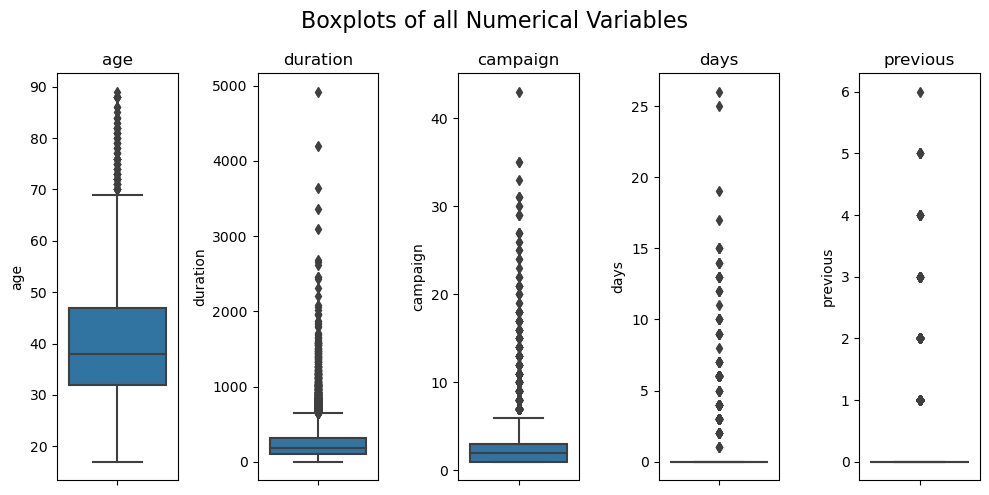

In [204]:
fig, axes = plt.subplots(1, 5, figsize=(10, 5))
axes = axes.flatten()

for i, name in enumerate(numerical_cols):
    if i < len(axes):
        ax = axes[i]
        sns.boxplot(y=df[name], ax=ax)
        ax.set_title(name)
        
for ax in axes[len(categorical_cols):]:
    ax.axis('off')

plt.suptitle("Boxplots of all Numerical Variables", fontsize=16)
plt.tight_layout()

the great amount of outliers is caused by the imbalance data, and due to the huge number of outliers in every column, i wont remove the outliers

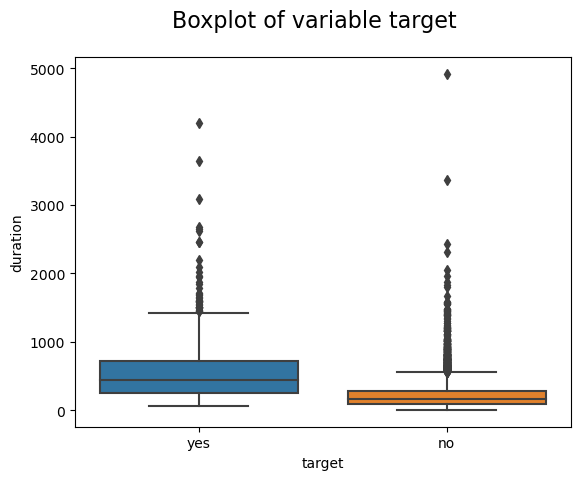

In [223]:
sns.boxplot(data=df, x="target", y="duration")

plt.suptitle("Boxplot of variable target", fontsize=16)
plt.show()

Based on the boxplots above, it is concluded that almost all variables, particularly "age", "duration", and "target", have numerous outliers. Due to the high volume of outliers, removing or modifying them is not feasible. Therefore, the next step will be to use a robust scaler, which is effective in handling outliers.

# Visualization

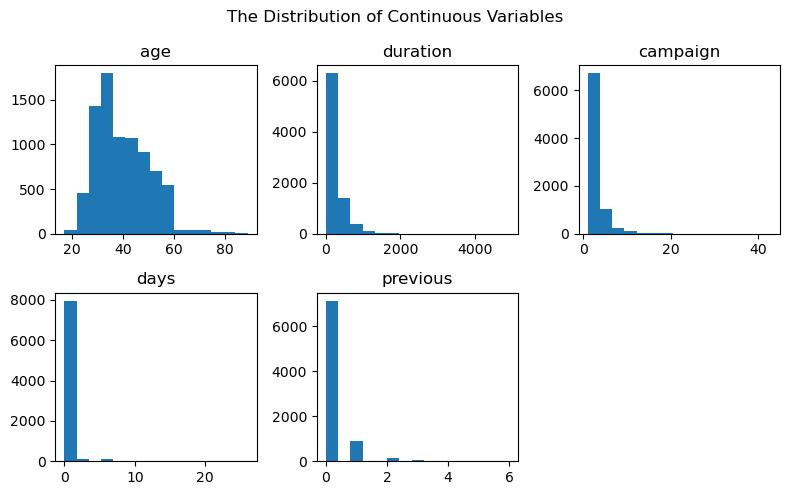

In [16]:
fig,axes = plt.subplots(2,3, figsize=(8,5))
axes = axes.flatten()

for i, name in enumerate(numerical_cols):
    ax = axes[i]
    ax.hist(df[name], label=name,bins=15)
    ax.set_title(name)
    
for ax in axes[len(numerical_cols):]:
    ax.axis('off')

plt.suptitle("The Distribution of Continuous Variables")
plt.tight_layout()

- Based on the subplot graphs above, it is concluded that all continuous variables are not normally distributed, but tend to be skewed right.
- Especially for the last 4 variables, the data is more concentrated in the range from 0 to 5.

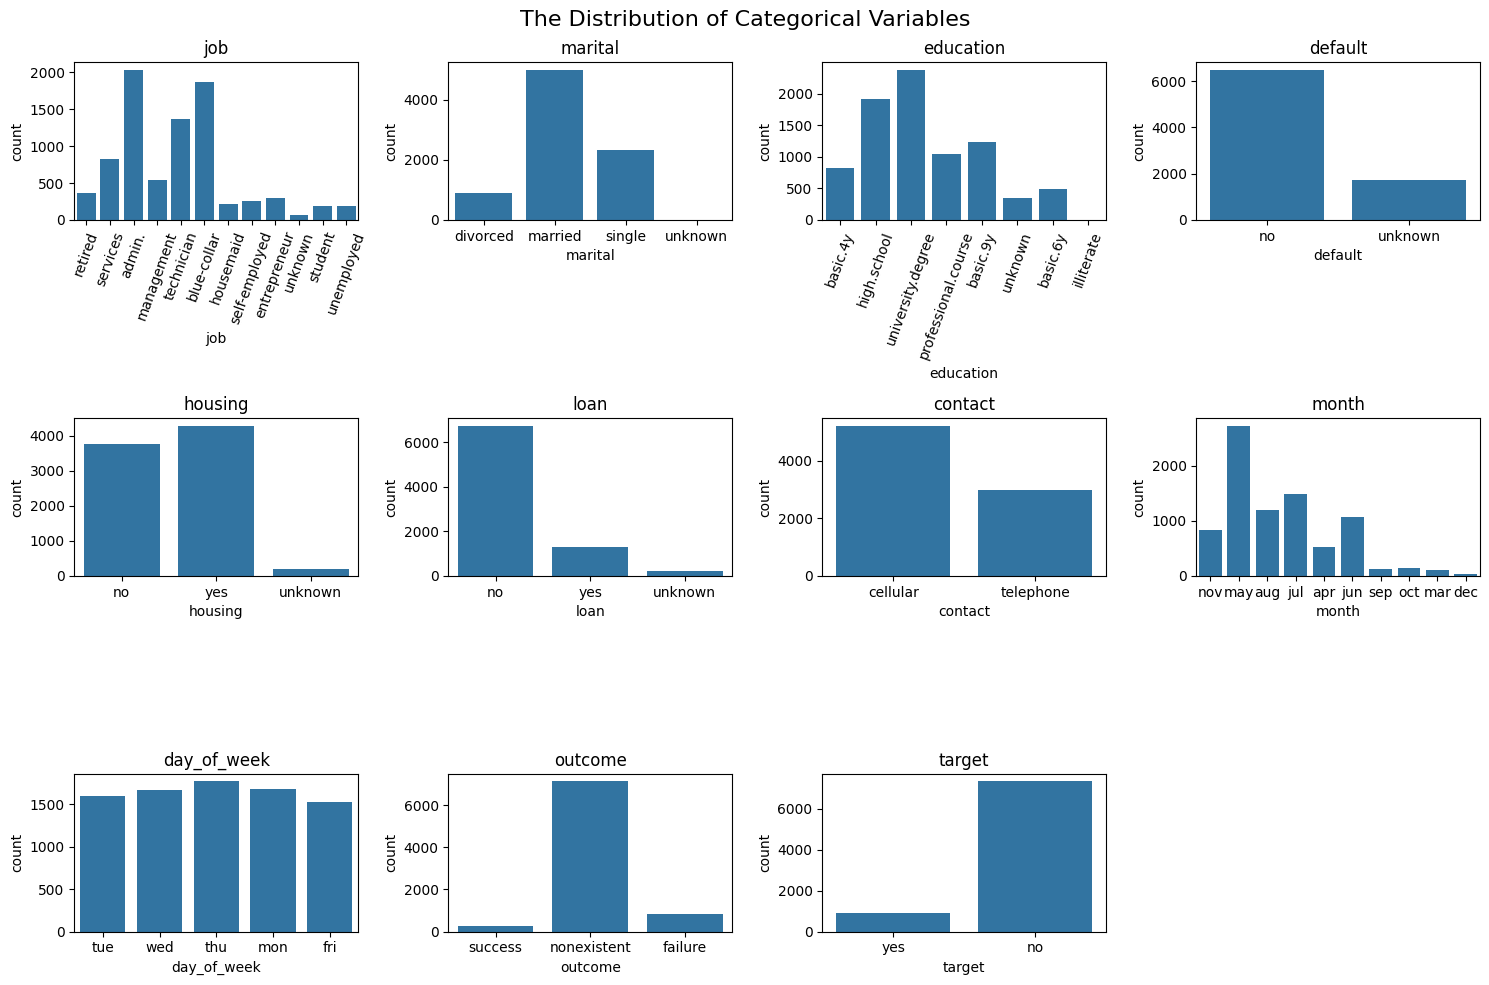

In [14]:
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
axes = axes.flatten()

for i, name in enumerate(categorical_cols):
    if i < len(axes):
        ax = axes[i]
        sns.countplot(x=df[name], ax=ax)
        ax.set_title(name)
        if(i==0 or i==2):
            ax.set_xticklabels(ax.get_xticklabels(), rotation=70)
        
for ax in axes[len(categorical_cols):]:
    ax.axis('off')

plt.suptitle("The Distribution of Categorical Variables", fontsize=16)
plt.tight_layout()

- Based on the subgraphs above, we can observe the distribution and frequency of each label for every categorical column
- For example, in the "job" column, the dominant occupations are "admin" and "blue-collar".

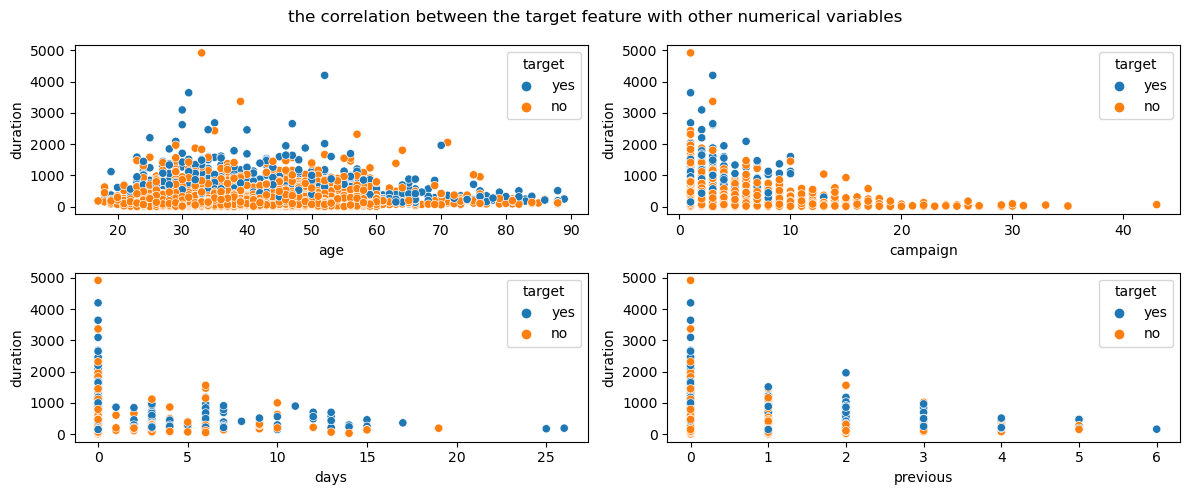

In [220]:
fig,axes = plt.subplots(2,2, figsize=(12,5))
axes = axes.flatten()

numerical = [col for col in numerical_cols if col != "duration"]

for i, name in enumerate(numerical):
    ax = axes[i]
    sns.scatterplot(data=df, x=name, y="duration", hue="target", ci=None, ax=ax) 
    
for ax in axes[len(numerical_cols):]:
    ax.axis('off')

plt.suptitle("the correlation between the target feature with other numerical variables", fontsize=12)
plt.tight_layout()

- From these subplots, we can observe the correlation between the most significant variable "duration" (based on validation from feature importance of model_RF below) with other numerical variables.
- Some insights that can be obtained. One of them is the individuals tend to keep buying before the 10th contact during the campaign.

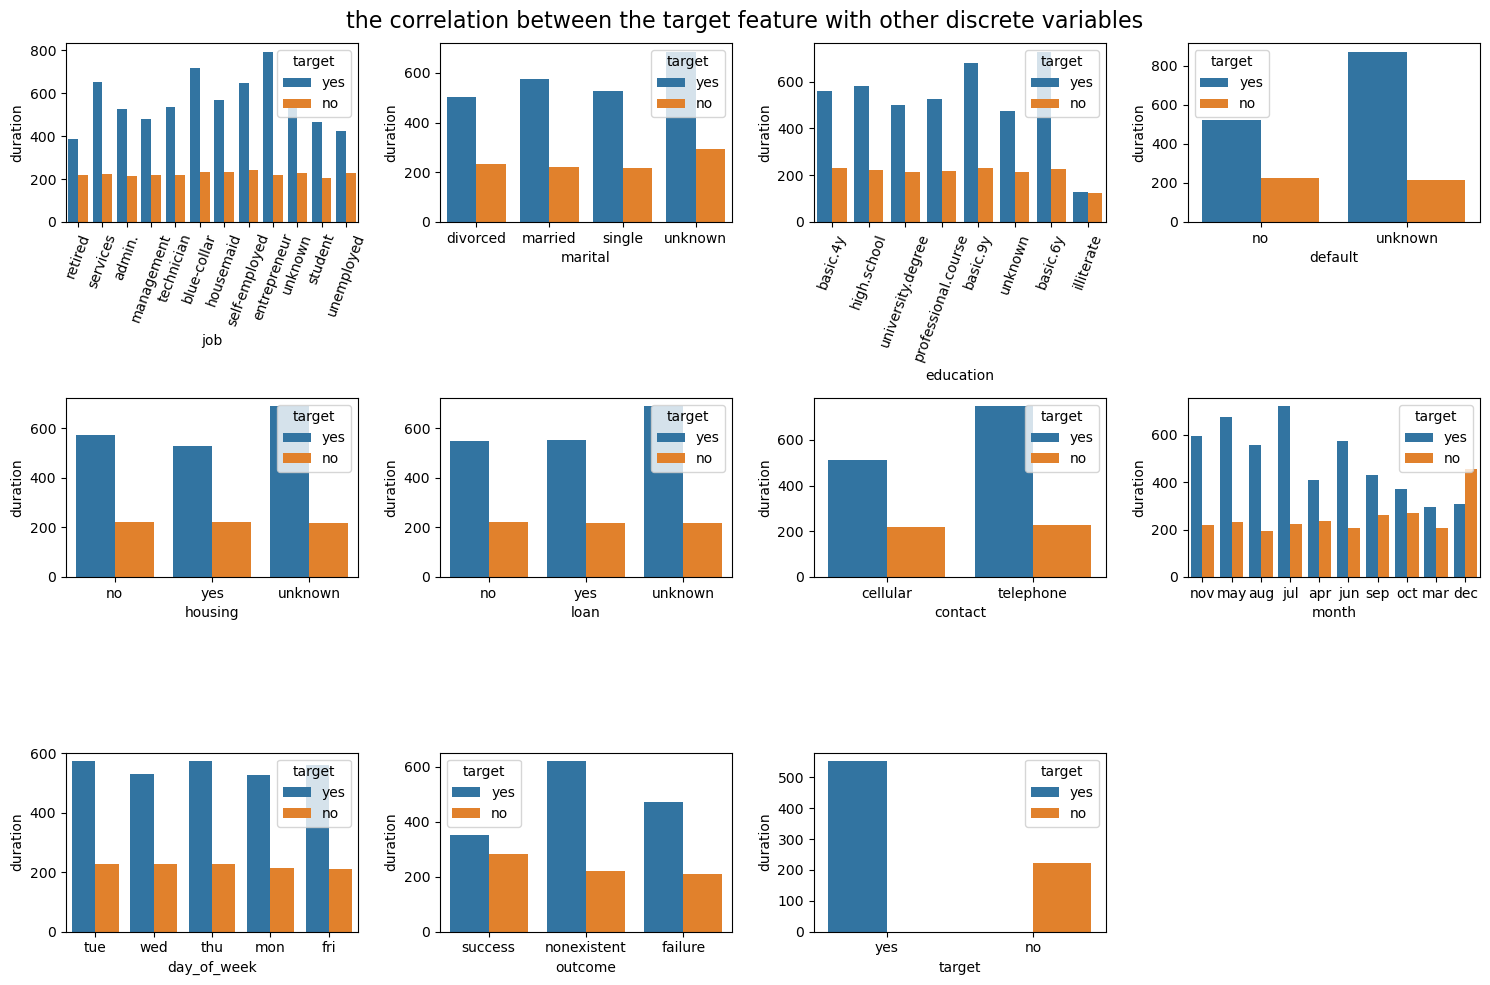

In [221]:
fig,axes = plt.subplots(3,4, figsize=(15,10))
axes = axes.flatten()

for i, name in enumerate(categorical_cols):
    ax = axes[i]
    sns.barplot(data=df, x=name, y="duration", hue="target", ci=None, ax=ax) 
    if(i==0 or i==2):
            ax.set_xticklabels(ax.get_xticklabels(), rotation=70)

for ax in axes[len(categorical_cols):]:
    ax.axis('off')

plt.suptitle("the correlation between the target feature with other categorical variables", fontsize=16)
plt.tight_layout()

Based on the subplots above, it appears that there is a noticeable contrast between "yes" and "no" for each variable. Additionally, the "month" variable shows that December is the only value that significantly outnumbers the others.

<AxesSubplot:>

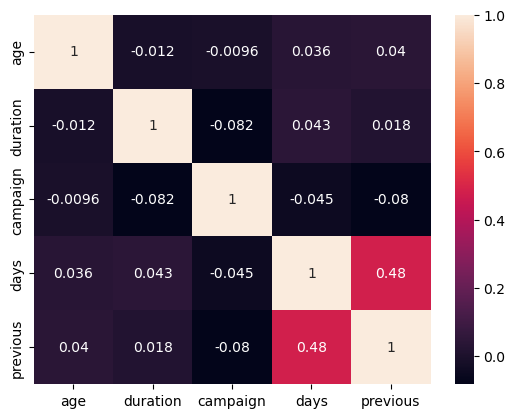

In [37]:
sns.heatmap(df.corr(), annot=True)

- Based on the heatmap showing correlations between numerical variables, it appears that almost every variable does not exhibit strong correlations, as most values are close to zero.
- The highest correlation observed is a positive correlation between the variables "days" and "previous". This indicates that if the value of one variable increases, the value of the other variable is also likely to increase, and vice versa.

# Data Transformations
Data transformation is performed separately on x_train and x_test after splitting the dataset. This ensures that no information from the test set leaks into the training process, maintaining the integrity of the model’s evaluation.

### Splitting Sets

In [21]:
input_df = df.drop(columns="target")
output_df = df["target"]

x_train,x_test,y_train,y_test = train_test_split(input_df, output_df, test_size=0.2, random_state=0)

### Value Replacement
Replacing values with appropriate ones (based on the features description) is essential, as keeping incorrect or placeholder values can negatively affect the model's output.

In [ ]:
x_train["days"] = x_train["days"].replace(999, 0)
x_test["days"] = x_test["days"].replace(999, 0)

### Filling-in empty values

In [219]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8238 entries, 0 to 8237
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          8238 non-null   int64  
 1   job          8230 non-null   object 
 2   marital      8238 non-null   object 
 3   education    8238 non-null   object 
 4   default      8238 non-null   object 
 5   housing      8238 non-null   object 
 6   loan         8238 non-null   object 
 7   contact      8238 non-null   object 
 8   month        8238 non-null   object 
 9   day_of_week  8238 non-null   object 
 10  duration     8226 non-null   float64
 11  campaign     8238 non-null   int64  
 12  days         8238 non-null   int64  
 13  previous     8238 non-null   int64  
 14  outcome      8238 non-null   object 
 15  target       8238 non-null   object 
dtypes: float64(1), int64(4), object(11)
memory usage: 1.0+ MB


there are 2 columns with empty values which are "job" and "duration"
- job is a categorical values, therefore i fill the empty values with its mode or the most frequent value
- duration has continuous values, therefore i fill the empty values with its mean 

In [22]:
x_train["duration"] = x_train["duration"].fillna(x_train["duration"].mean()) 
x_train["job"] = x_train["job"].fillna(x_train["job"].mode()[0])

x_test["duration"] = x_test["duration"].fillna(x_test["duration"].mean()) 
x_test["job"] = x_test["job"].fillna(x_test["job"].mode()[0])

In [12]:
print("empty values for x_train:\n", x_train.isna().sum())
print("empty values for x_test:\n", x_train.isna().sum())

empty values for x_train:
 age            0
job            0
marital        0
education      0
default        0
housing        0
loan           0
contact        0
month          0
day_of_week    0
duration       0
campaign       0
days           0
previous       0
outcome        0
dtype: int64
empty values for x_test:
 age            0
job            0
marital        0
education      0
default        0
housing        0
loan           0
contact        0
month          0
day_of_week    0
duration       0
campaign       0
days           0
previous       0
outcome        0
dtype: int64


### Feature Encoding

as the explanation above about "cardinality_checking"

In [23]:
print(many_labels)
print(less_labels)

['job', 'education', 'month', 'day_of_week']
['marital', 'default', 'housing', 'loan', 'contact', 'outcome']


#### label_encoder for variables that contain >4 labels

In [24]:
y_train_num = y_train.map({'yes': 1, 'no': 0})

In [25]:
target_encoder = ce.TargetEncoder(cols=many_labels, smoothing=1)
target_encoder.fit(x_train, y_train_num)

x_train_encoded = target_encoder.transform(x_train)
x_test_encoded = target_encoder.transform(x_test)

x_train_encoded.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,days,previous,outcome
3874,36,0.123998,single,0.129032,no,no,no,cellular,0.100518,0.104453,71.0,3,0,0,nonexistent
4577,41,0.123998,married,0.126549,no,yes,yes,cellular,0.183333,0.105422,254.0,1,0,0,nonexistent
5721,62,0.099548,divorced,0.126549,no,no,no,cellular,0.100518,0.105422,405.0,1,0,0,nonexistent
1238,43,0.110911,married,0.068020,no,no,no,cellular,0.084027,0.120986,110.0,6,0,0,nonexistent
1043,35,0.068045,single,0.126549,no,yes,yes,telephone,0.066946,0.106216,236.0,6,0,0,nonexistent


In [26]:
x_test_encoded.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,days,previous,outcome
8048,42,0.099526,married,0.129032,no,no,no,cellular,0.084027,0.120986,673.0,1,0,0,nonexistent
7925,24,0.092564,single,0.126549,no,no,no,cellular,0.066946,0.104453,145.0,4,0,1,failure
6915,64,0.244898,married,0.126549,no,no,no,cellular,0.100610,0.105422,146.0,1,3,1,success
2043,58,0.244898,married,0.107251,unknown,no,no,cellular,0.084027,0.106216,520.0,3,0,0,nonexistent
7265,29,0.068045,married,0.100592,no,no,no,telephone,0.066946,0.120986,34.0,8,0,0,nonexistent


In [27]:
encoder_file = 'target_encoder.pkl'
pickle.dump(target_encoder, open(encoder_file, 'wb'))

#### one_hot_encoding or dummies for variables that contain 4 labels or less

In [28]:
x_train_encoded = pd.get_dummies(x_train_encoded, columns=less_labels)
x_test_encoded = pd.get_dummies(x_test_encoded, columns=less_labels)
x_train_encoded.iloc[:, 9:] = x_train_encoded.iloc[:, 9:].astype(int)
x_test_encoded.iloc[:, 9:] = x_test_encoded.iloc[:, 9:].astype(int)
x_train_encoded.head()

,age,job,education,month,day_of_week,duration,campaign,days,previous,marital_divorced,...,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,outcome_failure,outcome_nonexistent,outcome_success
3874,36,0.123998,0.129032,0.100518,0.104453,71.0,3,0,0,0,...,0,0,1,0,0,1,0,0,1,0
4577,41,0.123998,0.126549,0.183333,0.105422,254.0,1,0,0,0,...,0,1,0,0,1,1,0,0,1,0
5721,62,0.099548,0.126549,0.100518,0.105422,405.0,1,0,0,1,...,0,0,1,0,0,1,0,0,1,0
1238,43,0.110911,0.068020,0.084027,0.120986,110.0,6,0,0,0,...,0,0,1,0,0,1,0,0,1,0
1043,35,0.068045,0.126549,0.066946,0.106216,236.0,6,0,0,0,...,0,1,0,0,1,0,1,0,1,0


In [29]:
x_test_encoded.head()

,age,job,education,month,day_of_week,duration,campaign,days,previous,marital_divorced,...,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,outcome_failure,outcome_nonexistent,outcome_success
8048,42,0.099526,0.129032,0.084027,0.120986,673.0,1,0,0,0,...,0,0,1,0,0,1,0,0,1,0
7925,24,0.092564,0.126549,0.066946,0.104453,145.0,4,0,1,0,...,0,0,1,0,0,1,0,1,0,0
6915,64,0.244898,0.126549,0.100610,0.105422,146.0,1,3,1,0,...,0,0,1,0,0,1,0,0,0,1
2043,58,0.244898,0.107251,0.084027,0.106216,520.0,3,0,0,0,...,0,0,1,0,0,1,0,0,1,0
7265,29,0.068045,0.100592,0.066946,0.120986,34.0,8,0,0,0,...,0,0,1,0,0,0,1,0,1,0


Since I only use tree-based models such as Decision Trees and Random Forests, scaling is not necessary. These models are not affected by the scale of the features because they make decisions based on the relative ordering of feature values, not their magnitudes. This means that whether the features are scaled or not won’t impact the performance of these models.

# Making Models

In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

### Decision Tree

In [106]:
model_DT = DecisionTreeClassifier()
model_DT = model_DT.fit(x_train_encoded, y_train)
y_predict = model_DT.predict(x_test_encoded)

print("Classfication Report\n", classification_report(y_test, y_predict))

Classfication Report
               precision    recall  f1-score   support

           0       0.94      0.92      0.93      1478
           1       0.39      0.47      0.43       170

    accuracy                           0.87      1648
   macro avg       0.67      0.69      0.68      1648
weighted avg       0.88      0.87      0.88      1648



### Random Forest

In [142]:
model_RF = RandomForestClassifier()
model_RF = model_RF.fit(x_train_encoded, y_train)
y_predict = model_RF.predict(x_test_encoded)

print("Classfication Report\n", classification_report(y_test, y_predict))

Classfication Report
               precision    recall  f1-score   support

           0       0.94      0.96      0.95      1478
           1       0.58      0.45      0.51       170

    accuracy                           0.91      1648
   macro avg       0.76      0.71      0.73      1648
weighted avg       0.90      0.91      0.90      1648



CONCLUSION:
- Although the accuracy score is quite high, the F1-score remains low for the minority class.
- The next step to address this issue is to apply parameter tuning using F1-score as the scoring metric and implement Synthetic Minority Over-sampling Technique (SMOTE) to generate minority class data.

In [32]:
from imblearn.over_sampling import SMOTE

In [149]:
smote = SMOTE(random_state=0)
x_train_smote, y_train_smote = smote.fit_resample(x_train_encoded, y_train)

model_RF_smote = RandomForestClassifier()
model_RF_smote = model_RF_smote.fit(x_train_smote, y_train_smote)
y_predict = model_RF_smote.predict(x_test_encoded)

print("Classfication Report\n", classification_report(y_test, y_predict))

Classfication Report
               precision    recall  f1-score   support

           0       0.95      0.96      0.95      1478
           1       0.58      0.52      0.55       170

    accuracy                           0.91      1648
   macro avg       0.76      0.74      0.75      1648
weighted avg       0.91      0.91      0.91      1648



By applying SMOTE, the F1-score of minority values increases by 4%

In [35]:
with open('model_RF_smote.pkl', 'wb') as file:
    pickle.dump(model_RF_smote, file)

saving the model to pickle for future deployment

#### feature importance 
from the RandomForestClassifier model

In [160]:
feature_importances = model_RF.feature_importances_

feature_names = x_train_encoded.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

feature_names 

Index(['age', 'job', 'education', 'month', 'day_of_week', 'duration',
       'campaign', 'days', 'previous', 'marital_married', 'marital_single',
       'marital_unknown', 'default_unknown', 'housing_unknown', 'housing_yes',
       'loan_unknown', 'loan_yes', 'contact_telephone', 'outcome_nonexistent',
       'outcome_success'],
      dtype='object')

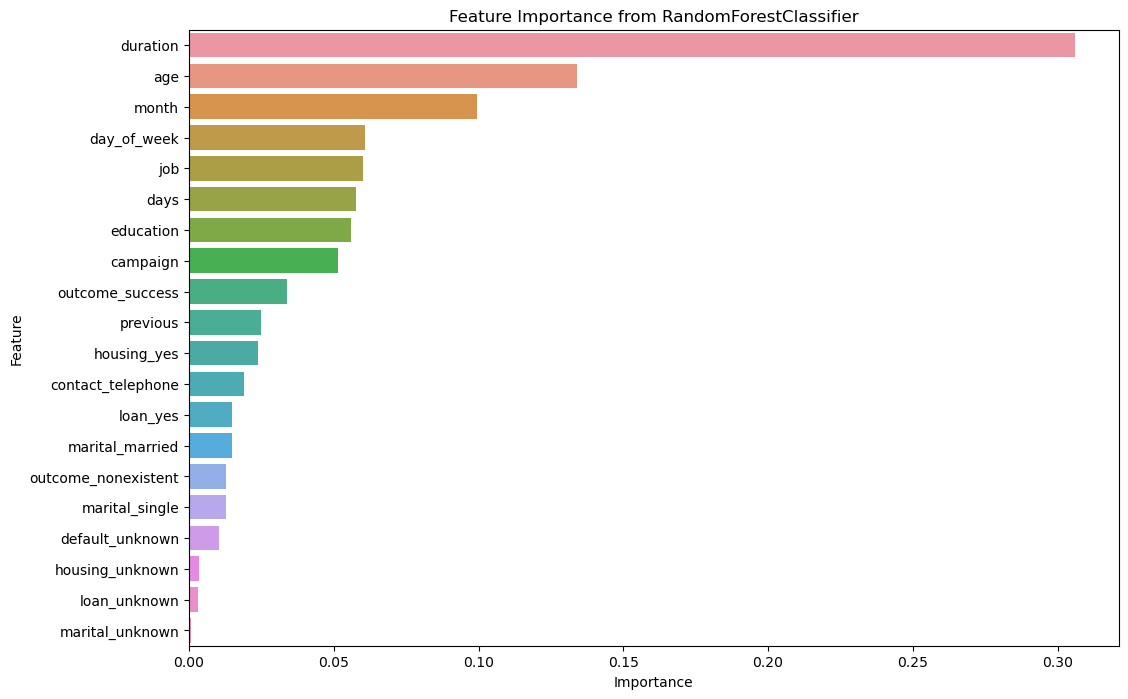

In [161]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance from RandomForestClassifier')
plt.show()

- Based on the feature importance results obtained from the Random Forest model, the model learned that the variable "duration" has the most significant impact in predicting the target variable.
- Additionally, this variable "duration" was also used as the dependent variable (y-axis) in the bar plot and scatter plot correlations above.